# Notes
- consider adding the title of the book and the author to some of the prompts where it's useful; especially where ambiguity about the purpose of the text could significantly change the stuff generated. So the judged worthy for questions prompt, some of the RP prompts, etc.

In [1]:
# Put your desired quant of your desired model in the relevant directories
RP_MODEL = "./rp_model" # model used for RP tasks, probably going to use Sao10K/Euryale-1.3-L2-70b
LOGICAL_MODEL = "./logical_model/airoboros-l2-13b-3.1.1.Q8_0.gguf" # model used for decision-making and base question generation (should be "smart")
RAM_IS_LIMITED = True # change this to false if you can fit both models on your GPU at once

In [2]:
from transformers import AutoTokenizer
from tqdm import tqdm # it's not machine learning if there's no progress bar
import re

tokenizer = AutoTokenizer.from_pretrained("Gryphe/MythoMax-L2-13b")

def paragraph_chunking_algorithm(file_path, tokenizer, avg_line_length_threshold=10, max_token_length=1500, window_length=5, stop_line_length=10):
    """
    This function takes a plaintext file and chunks it into important sequences of paragraphs.
    
    :param file_path: Path to the plaintext file
    :param tokenizer: SentencePiece tokenizer
    :param avg_line_length_threshold: The minimum average line length (in words) to consider a paragraph important
    :param max_token_length: The maximum token length for a paragraph sequence
    :param window_length: The number of paragraphs to consider in the sliding window
    :param stop_line_length: The maximum line length (in characters) for a line to be considered a stopping line if in all caps
    :return: List of paragraph sequences
    """
    # Initialize variables
    chunks = []
    current_chunk = []
    sliding_window = []
    token_count = 0

    with open(file_path, 'r', encoding='utf-8') as f:
        content = f.read()

    # Filter out non-paragraph content
    content = re.sub(r'^.*?START OF (THIS|THE) PROJECT GUTENBERG EBOOK.*$\n', '', content, flags=re.MULTILINE)
    content = re.sub(r'^.*?END OF (THIS|THE) PROJECT GUTENBERG EBOOK.*$\n', '', content, flags=re.MULTILINE)

    # Improve paragraph detection
    paragraphs = re.split('\n{2,}', content)

    for paragraph in paragraphs:
        # Skip short lines that are likely not part of the main text
        if len(paragraph.split()) < avg_line_length_threshold:
            continue

        lines = paragraph.split('\n')
        
        # Check for stopping line
        if any(len(line) <= stop_line_length and line.isupper() for line in lines):
            if current_chunk:
                chunks.append((current_chunk,file_path.replace(".txt","")))
            current_chunk = []
            sliding_window = []
            token_count = 0
            continue

        # Add paragraph to sliding window
        sliding_window.append(paragraph)
        if len(sliding_window) > window_length:
            removed_paragraph = sliding_window.pop(0)
            token_count -= len(tokenizer.encode(removed_paragraph))
        
        # Calculate average line length
        avg_line_length = sum(len(line.split()) for line in lines) / len(lines)
        
        # If average line length is above threshold, add to current chunk
        if avg_line_length >= avg_line_length_threshold:
            token_count += len(tokenizer.encode(paragraph))
            if token_count <= max_token_length:
                current_chunk.append(paragraph)
            else:
                chunks.append((current_chunk,file_path.replace(".txt","")))
                current_chunk = [paragraph]
                token_count = len(tokenizer.encode(paragraph))
                
        # If current chunk is non-empty and new paragraph doesn’t meet criteria, save current chunk
        elif current_chunk:
            chunks.append((current_chunk,file_path.replace(".txt","")))
            current_chunk = []
            token_count = 0
    
    # Add last chunk if it exists
    if current_chunk:
        chunks.append((current_chunk,file_path.replace(".txt","")))
    
    return chunks

In [3]:
source_texts = [
    # "A Short History of the World, by HG Wells, published 1922.txt",
                # "Simple Sabotage, by the Office of Strategic Services, published 1944.txt", 
                "A Short History of the World, by HG Wells, published 1922.txt"
                ]
paragraphs = []
for source_text in source_texts:
    c = paragraph_chunking_algorithm(source_text,tokenizer)
    paragraphs += c # each chunk is a tuple, with the source text being the second thing in that tuple

# c = paragraph_chunking_algorithm("hgwells-short-history.txt",tokenizer)

In [4]:
len(paragraphs)

222

In [7]:
paragraphs[4]

(['Slowly by degrees as one million of years followed another, this fiery\nscene would lose its eruptive incandescence.  The vapours in the sky\nwould rain down and become less dense overhead; great slaggy cakes of\nsolidifying rock would appear upon the surface of the molten sea, and\nsink under it, to be replaced by other floating masses.  The sun and\nmoon growing now each more distant and each smaller, would rush with\ndiminishing swiftness across the heavens. The moon now, because of its\nsmaller size, would be already cooled far below incandescence, and\nwould be alternately obstructing and reflecting the sunlight in a\nseries of eclipses and full moons.',
  'And so with a tremendous slowness through the vastness of time, the\nearth would grow more and more like the earth on which we live, until\nat last an age would come when, in the cooling air, steam would begin\nto condense into clouds, and the first rain would fall hissing upon the\nfirst rocks below.  For endless millenia t

In [8]:
# since gutenberg adds newlines in a bunch of places to their plaintext files, we replace newlines within paragraphs with spaces, and also correct for other formatting issues (double spaces, _italics_ instead of *italics*)
def fix_text(to_replace_arr, text):
    for strtup in to_replace_arr:
        return text.replace(strtup[0],strtup[1])

conversions = [("\n"," "), ("  ", " ")]

paragraphs_processed = [("\n\n".join([fix_text(conversions,paragraph) for paragraph in seq[0]]),seq[1]) for seq in paragraphs]

In [9]:
paragraphs_processed[4]

('Slowly by degrees as one million of years followed another, this fiery scene would lose its eruptive incandescence.  The vapours in the sky would rain down and become less dense overhead; great slaggy cakes of solidifying rock would appear upon the surface of the molten sea, and sink under it, to be replaced by other floating masses.  The sun and moon growing now each more distant and each smaller, would rush with diminishing swiftness across the heavens. The moon now, because of its smaller size, would be already cooled far below incandescence, and would be alternately obstructing and reflecting the sunlight in a series of eclipses and full moons.\n\nAnd so with a tremendous slowness through the vastness of time, the earth would grow more and more like the earth on which we live, until at last an age would come when, in the cooling air, steam would begin to condense into clouds, and the first rain would fall hissing upon the first rocks below.  For endless millenia the greater part 

In [11]:
from llama_cpp import Llama

In [12]:
# rp_llm = Llama(model_path=RP_MODEL,n_ctx=4096,n_gpu_layers=100) # load the RP llp and offload everything

In [13]:
logic_llm = Llama(model_path=LOGICAL_MODEL,n_ctx=4096,n_gpu_layers=100,verbose=False) # load the logical LLM and offload everything

llama_model_loader: loaded meta data with 21 key-value pairs and 363 tensors from ./logical_model/airoboros-l2-13b-3.1.1.Q5_K_M.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q5_K     [  5120, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  5120,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q6_K     [ 13824,  5120,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight q5_K     [  5120, 13824,     1,     1 ]
llama_model_loader: - tensor    4:              blk.0.ffn_up.weight q5_K     [  5120, 13824,     1,     1 ]
llama_model_loader: - tensor    5:            blk.0.ffn_norm.weight f32      [  5120,     1,     1,     1 ]
llama_model_loader: - tensor    6:              blk.0.attn_k.weight q5_K     [  5120,  5120,     1,     1 ]
llama_model_loader: - tensor    7:         blk.0.attn_output.weight q5_K     [  5120,  5120, 

In [47]:
# This is in no way best practices, but all my prompts being searchable and separate files is a good way to make my life easier.
import pkgutil
import importlib
import generation_functions  # This is the package directory
import sys

sys.path.append('./generation_functions')

# First, import all modules so they can be reloaded
for _, module_name, _ in pkgutil.iter_modules(generation_functions.__path__, generation_functions.__name__ + '.'):
    importlib.import_module(module_name)

# Now, reload each module and import all callable attributes
for _, module_name, _ in pkgutil.iter_modules(generation_functions.__path__, generation_functions.__name__ + '.'):
    # Reload the module
    module = importlib.reload(sys.modules[module_name])
    # Iterate through each attribute in the reloaded module
    for attribute_name in dir(module):
        # Retrieve the attribute
        attribute = getattr(module, attribute_name)
        if callable(attribute):
            # If it's callable, it's a function or class, so you set it in the globals dictionary
            globals()[attribute_name] = attribute

root ::= analyze-step understand-step compare-step root_4 final-step [<U+000A>] 
analyze-step ::= [S] [t] [e] [p] [ ] analyze-step_13 [0-9] [.] [ ] [A] [n] [a] [l] [y] [z] [e] analyze-step_14 [.] [<U+000A>] 
understand-step ::= [S] [t] [e] [p] [ ] understand-step_15 [0-9] [.] [ ] [U] [n] [d] [e] [r] [s] [t] [a] [n] [d] understand-step_16 [.] [<U+000A>] 
compare-step ::= [S] [t] [e] [p] [ ] compare-step_6 [0-9] [.] [ ] [C] [o] [m] [p] [a] [r] [e] [ ] [t] [h] [e] [ ] compare-step_7 [ ] [P] [a] [r] [t] [ ] [o] [f] [ ] [t] [h] [e] [ ] [A] [n] [s] [w] [e] [r] [ ] [w] [i] [t] [h] [ ] [t] [h] [e] [ ] [T] [e] [x] [t] [:] [ ] [c] [h] [e] [c] [k] [ ] [i] [f] [ ] [t] [h] [e] [ ] [t] [e] [x] [t] [ ] compare-step_8 compare-step_9 compare-step_10 [.] [<U+000A>] 
root_4 ::= compare-step root_4 | compare-step 
final-step ::= [S] [t] [e] [p] [ ] final-step_11 [0-9] [.] [ ] [F] [i] [n] [a] [l] [ ] [J] [u] [d] [g] [e] [m] [e] [n] [t] [:] [ ] final-step_12 [.] [<U+000A>] 
compare-step_6 ::= [0-9] | 
compa

from_string grammar:

from_string grammar:

from_string grammar:

from_string grammar:

from_string grammar:

from_string grammar:

from_string grammar:

from_string grammar:

from_string grammar:

from_string grammar:

from_string grammar:

from_string grammar:

from_string grammar:

from_string grammar:

from_string grammar:

from_string grammar:

from_string grammar:

from_string grammar:

from_string grammar:

from_string grammar:

from_string grammar:



In [49]:
# Determine which paragraphs are worthy of making questions from
judged_worthy_for_questions = []
for idx, p in tqdm(enumerate(paragraphs_processed[0:5])): # for each paragraph, try determining if it is suitable for questions or not, at most three times each
    judgement = judge_paragraph(p,logic_llm)
    judged_worthy_for_questions.append(judgement)
    try:
        if judgement[0] is not None:
            print(f"DEBUG model decided that index {idx} was suitable")
        elif judgement[0] is None:
            print(f"DEBUG model decided that index {idx} was not suitable")
    except:
        print(f"DEBUG max retries exceeded for index {idx}")
    
        
            


1it [00:21, 21.42s/it]



DETERMINATION:
------
 Unsuitable.



---------

DEBUG decided that index 0 was not suitable


2it [00:48, 24.61s/it]



DETERMINATION:
------
 Suitable.



---------

DEBUG decided that index 1 was suitable


3it [01:19, 27.65s/it]



DETERMINATION:
------
 Suitable.



---------

DEBUG decided that index 2 was suitable


4it [02:03, 34.04s/it]



DETERMINATION:
------
 Suitable.



---------

DEBUG decided that index 3 was suitable


5it [02:30, 30.14s/it]



DETERMINATION:
------
 Suitable.



---------

DEBUG decided that index 4 was suitable


In [51]:
import matplotlib.pyplot as plt
from collections import Counter

def filter_and_graph(tuples):
    # Count the occurrences of None and non-None for each source text
    source_counts = Counter()
    for paragraph, source in tuples:
        if paragraph is None:
            source_counts[source] = source_counts.get(source, [0, 0])
            source_counts[source][0] += 1
        else:
            source_counts[source] = source_counts.get(source, [0, 0])
            source_counts[source][1] += 1

    # Prepare data for the graph
    labels = list(source_counts.keys())
    none_counts = [source_counts[source][0] for source in labels]
    non_none_counts = [source_counts[source][1] for source in labels]

    # Plotting the graph
    x = range(len(labels))
    plt.bar(x, none_counts, width=0.4, label='Not suitable', align='center')
    plt.bar(x, non_none_counts, width=0.4, label='Valid Paragraphs', align='edge')
    plt.xlabel('Source Text')
    plt.ylabel('Number of Paragraphs')
    plt.title('Paragraphs Suitable for Questions by Source Text')
    plt.xticks(x, labels, rotation='vertical')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Filter out tuples with None and return the new list
    filtered_list = [t for t in tuples if t[0] is not None]
    return filtered_list


/var/folders/ky/hw_2k4fn3dvcm9n_kcqzl0xc0000gn/T/ipykernel_6092/172253912.py:29: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


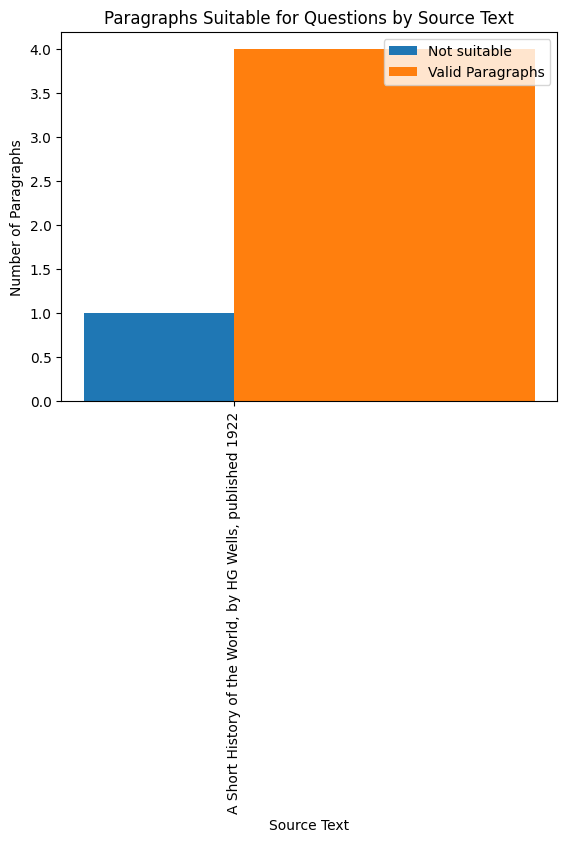

In [52]:
filtered_worthy_for_questions = filter_and_graph(judged_worthy_for_questions)

In [53]:

# Answer generation code, begin.
# structure: define a series of helpers, then define the control flow, exception handling, retries etc. in a for loop that iterates over the processed sequences of paragraphs at the end in another cell

# Since some paragraphs can be much shorter 
# First off, question generation.

# Each local LLM function essentially has 3 phases: prompt, regex to extract response, and reaction to that response.
# However I'm not going to build an abstraction for that because I need fine control.

# If any function fails to make things, it won't throw, it'll just return None.

# Strengths of open source AI: hella cheap, very customizable, you can call it as much as you want
# Downside: you need very good regexes to catch its outputs


In [54]:
# Formatting fixer, generalist prompt

# TODO

In [55]:
print(filtered_worthy_for_questions[0])

('The story of our world is a story that is still very imperfectly known. A couple of hundred years ago men possessed the history of little more than the last three thousand years. What happened before that time was a matter of legend and speculation.  Over a large part of the civilized world it was believed and taught that the world had been created suddenly in 4004 B.C., though authorities differed as to whether this had occurred in the spring or autumn of that year. This fantastically precise misconception was based upon a too literal interpretation of the Hebrew Bible, and upon rather arbitrary theological assumptions connected therewith.  Such ideas have long since been abandoned by religious teachers, and it is universally recognized that the universe in which we live has to all appearances existed for an enormous period of time and possibly for endless time.  Of course there may be deception in these appearances, as a room may be made to seem endless by putting mirrors facing ea

In [56]:
# Control flow helpers

# Change this value to change how many times the checks must pass consecutively for a thing to be accepted

# EXPERIMENTAL ADJUSTMENT TO THE PIPELINE: majority rules for accuracy checks, instead of requiring unanimous approval, since it can be quite finicky
# CHANGE: replaced all things like `if passed_checks == DOUBLE_CHECK_COUNTER:` with if passed_checks > ceil(DOUBLE_CHECK_COUNTER/2)
import logging
from math import ceil


# Setup logging
logging.basicConfig(filename='data_generation.log', 
                    filemode='a', 
                    format='%(asctime)s - %(levelname)s - %(message)s',
                    level=logging.INFO)

DOUBLE_CHECK_COUNTER = 3 # Set to 1 to check only once; set to 2 to check twice; set to 3 to check thrice; set to 0 to break everything

def tokenize_and_check_length(text):
    tokens = tokenizer.encode(text)
    return len(tokens) > 500, tokens

def vet_answer_accuracy_loop(qa_tuple,total_retries):
    try:
        qtuple = qa_tuple
        print(f"\n\nStarting ACCURACY loop for question: {qtuple[0]}, context: {qtuple[2]}")
        passed_checks = 0
        times_checked = 0
        dissenting_reasoning = ""
        while times_checked < DOUBLE_CHECK_COUNTER:
            print(f"\n\nACCURACY CALL CHECK ANSWER: {qtuple[0]}, context: {qtuple[2]}, retries: {total_retries}, dissenting reasoning: {dissenting_reasoning}")
            judgement = check_answer(qtuple, logic_llm)
            if not judgement[0]:  # if not accurate
                dissenting_reasoning = judgement[1]
            else:
                passed_checks += 1
            times_checked+=1
            if passed_checks > ceil(DOUBLE_CHECK_COUNTER/2):
                break
            failed_checks = times_checked - passed_checks
            if failed_checks > ceil(DOUBLE_CHECK_COUNTER/2):
                break
        
        if passed_checks > ceil(DOUBLE_CHECK_COUNTER/2):  # if question checks passed
            print(f"\n\ANSWER ACCURACY CHECKS PASSED retries: {total_retries}")
            return qtuple
        else:
            # Generate new question and restart the loop
            print(f"\n\nACCURACY CHECKS FAILED - SENDING BACK TO QUESTION LOOP retries: {total_retries}")
            total_retries += 1
            qtuple = generate_new_question(qtuple, logic_llm)
            return vet_question_loop(qtuple,total_retries) # going to get one hell of a call stack by the end of this, but it should be fine
    except Exception as e:
        print("!!ERROR!!")
        print(e)
        pass
    
    return (None, None, None, qtuple[3])

def vet_answer_relevance_loop(qa_tuple,total_retries):
    try:
        qtuple = qa_tuple
        print(f"\n\nStarting RELEVANCE loop for question: {qtuple[0]}, context: {qtuple[2]}")
        passed_checks = 0
        times_checked = 0
        dissenting_reasoning = ""
        while passed_checks < DOUBLE_CHECK_COUNTER:
            print(f"\n\nRELEVANCE CALL CHECK ANSWER: {qtuple[0]}, context: {qtuple[2]}, retries: {total_retries}, dissenting reasoning: {dissenting_reasoning}")
            judgement = check_answer_relevancy_with_text(qtuple, logic_llm)
            if not judgement[0]:  # if not relevant
                dissenting_reasoning = judgement[1]
            else:
                passed_checks += 1
            times_checked += 1
            if passed_checks > ceil(DOUBLE_CHECK_COUNTER/2):
                break
            failed_checks = times_checked - passed_checks
            if failed_checks > ceil(DOUBLE_CHECK_COUNTER/2):
                break
        
        if passed_checks > ceil(DOUBLE_CHECK_COUNTER/2):
            print(f"\n\nRELEVANCE CHECKS PASSED")
            return vet_answer_accuracy_loop(qtuple,total_retries)
        else:
            print(f"\n\nRELEVANCE CHECKS FAILED - SENDING BACK TO QUESTION LOOP")
            total_retries += 1
            qtuple = generate_new_question(qtuple, logic_llm)
            return vet_question_loop(qtuple,total_retries)
    except Exception as e:
        print("!!ERROR!!")
        print(e)
        pass
    
    return (None, None, None, qtuple[3])

def vet_question_loop(qa_tuple, total_retries=0):
    try:
        qtuple = qa_tuple
        print(f"\n\nStarting QUESTION loop for question: {qtuple[0]}, context: {qtuple[2]}")
        while total_retries <= 4:
            passed_checks = 0
            times_checked = 0
            dissenting_reasoning = ""
            while times_checked < DOUBLE_CHECK_COUNTER:
                print(f"\n\nQUESTION CALL CHECK ANSWER: {qtuple[0]}, context: {qtuple[2]}, retries: {total_retries}, dissenting reasoning: {dissenting_reasoning}")
                judgement = check_question(qtuple, logic_llm)
                if not judgement[0]:  # if not relevant
                    dissenting_reasoning = judgement[1]
                else:
                    passed_checks += 1
                times_checked += 1
                if passed_checks > ceil(DOUBLE_CHECK_COUNTER/2):
                    break
                failed_checks = times_checked - passed_checks
                if failed_checks > ceil(DOUBLE_CHECK_COUNTER/2):
                    break
            
            if passed_checks > ceil(DOUBLE_CHECK_COUNTER/2):  # if all question checks passed
                print(f"\n\nQUESTION CHECKS PASSED retries: {total_retries}")
                return vet_answer_relevance_loop(qtuple,total_retries)
            else:
                # Generate new question and restart the loop
                print(f"\n\nQUESTION CHECKS FAILED - GENERATING NEW QUESTION retries: {total_retries}")
                total_retries += 1
                if (total_retries > 4): # don't regen question if we're already at max regens
                    qtuple = generate_new_question(qtuple, logic_llm) 
                # no calling of vet_question_loop, since we're already in a while loop
    except Exception as e:
        print("!!ERROR!!")
        print(e)
    
    return (None, None, None, qtuple[3])


In [57]:
# control flow
import json
import os

# Directory for QA tuples
qa_tuples_dir = './qatuples_raw'
if not os.path.exists(qa_tuples_dir):
    os.makedirs(qa_tuples_dir)


# Generate questions CoT-style
vetted_qa_tuples = [] # tuple list of qa tuples that have been judged good
for idx, para in enumerate(tqdm(filtered_worthy_for_questions)):
    try:
        print(f"\n\n\nOUTER LOOP CALL GENERATE QPLAN para: {para}, \n\n idx: {idx}")
        plan = generate_questions_plan(para,logic_llm)
        print(f"\n\n\nOUTER LOOP CALL GENERATE Q: {para}, \n\n idx: {idx} \n\n plan: {plan}")
        question_answer_tuples = generate_questions(para,plan,logic_llm)
        for qnum, question_answer_tuple in enumerate(question_answer_tuples):
            print(f"\n\n=======!!=BEGIN VETTING QA TUPLE {idx}_{qnum}=!!=======\n\n")
            good_qa_tuple = vet_question_loop(question_answer_tuple)
            
            # Write to file if the tuple is not None
            if good_qa_tuple[0] is not None:
                file_path = os.path.join(qa_tuples_dir, f'para_{idx}_q_{qnum}.json')
                with open(file_path, 'w') as file:
                    json.dump(good_qa_tuple, file, indent=4)
            
            vetted_qa_tuples.append(good_qa_tuple) # We must filter out all None values at the end; but appending Nones lets us know where things went wrong, and how often.
    except Exception as e:
        print(f"Q ERROR: {e}")
        
print("-------------- QUESTIONS CREATED ------------- STATS SO FAR:")
nones= list(filter(lambda x: x[0] is None, vetted_qa_tuples))
print(f"Nones: {len(nones)}")
print(f"Non-nones: {len(vetted_qa_tuples) - len(nones)}")
print(f"Total: {len(vetted_qa_tuples)}")
# filter out all None values
vetted_qa_tuples = [qa for qa in vetted_qa_tuples if qa[0] is not None]
print("---------------- ONTO EXAMPLES GENERATION-------------------")


  0%|          | 0/4 [00:00<?, ?it/s]

COMPLETION:

----------------------
# Input:
You are an expert educational AI that, given a paragraph or two from a text, will narrow down what kind of high-quality educational questions could be asked based on the paragraphs, and *only* based on the paragraphs. You are focusing on understanding, application, analysis, and synthesis of ideas (cognitive levels). For now, your goal is to just write a good, comprehensive plan for generating questions that require critical thinking to solve; what aspects of the provided paragraphs they might cover, etc. The questions should ONLY cover material that explictly appears in the provided paragraphs. The topics you think of should lean towards longer, more difficult questions, that require some thought to solve — but which can still be solved if you know the information in the paragraphs. Essentially: the question will test comprehension and memorization of real information that would be worthy to teach. Your task includes analyzing the text, thi

 25%|██▌       | 1/4 [1:16:50<3:50:32, 4610.83s/it]

# Input:
You are an expert educational AI. Someone has written an answer to a question (this question is based on a few provided paragraphs of text) but their answer includes information that's not provided by the text, and thus it might be flawed. Given these paragraphs, a question based on the paragraphs, the flawed answer to the question, and the explanation of why the answer deviates from the text, you will write the correct answer to the question that only uses info in the text. 

Text: """The story of our world is a story that is still very imperfectly known. A couple of hundred years ago men possessed the history of little more than the last three thousand years. What happened before that time was a matter of legend and speculation.  Over a large part of the civilized world it was believed and taught that the world had been created suddenly in 4004 B.C., though authorities differed as to whether this had occurred in the spring or autumn of that year. This fantastically precise m

 25%|██▌       | 1/4 [1:46:31<5:19:35, 6391.81s/it]


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

# Counting nones vs non-nones for questions per source text
qa_counts = {}
for qa in vetted_qa_tuples:
    source_text = qa[3] if qa[3] is not None else 'Unknown'
    if source_text not in qa_counts:
        qa_counts[source_text] = {'None': 0, 'Valid': 0}
    
    if qa[0] is None:
        qa_counts[source_text]['None'] += 1
    else:
        qa_counts[source_text]['Valid'] += 1

# Plotting
fig, ax = plt.subplots()

# Data for plotting
sources = list(qa_counts.keys())
none_counts = [qa_counts[src]['None'] for src in sources]
valid_counts = [qa_counts[src]['Valid'] for src in sources]

# Creating the bar plot
ax.bar(sources, valid_counts, label='Valid QA Tuples')
ax.bar(sources, none_counts, bottom=valid_counts, label='None QA Tuples')

# Adding labels and title
ax.set_xlabel('Source Text')
ax.set_ylabel('Count')
ax.set_title('Number of None vs Valid QA Tuples per Source Text')
ax.legend()

# Rotate labels for better readability
plt.xticks(rotation=45)

plt.show()


In [1]:
# logic_llm = Llama(model_path=LOGICAL_MODEL,n_ctx=4096,n_gpu_layers=100,verbose=False) # load the logical LLM and offload everything


# if RAM_IS_LIMITED:
#     del logic_llm # goodbye sense, now it's time to get funky
# well, at least more fluent and conversational

# Not implemented yet. Most systems can probably only run one 70b anyway.
# if not RAM_IS_LIMITED:
#     rp_llm = Llama(model_path=RP_MODEL,n_ctx=4096,n_gpu_layers=100,verbose=False) # load the RP LLM and offload everything else
# else:
#     rp_llm = logic_llm # Quick and dirty way to avoid having to rename things or decide things everywhere. Just use the logic llm for both. (ASSUMPTION: this does not clone the logic llm).

SyntaxError: unexpected EOF while parsing (2886001572.py, line 10)

In [ ]:
# helpers for generating examples
def make_character(qa_tuple):
    # generating the character first will allow for more creativity regarding what kinds of scenarios (and characters!) can be made. Doing the scenario first will probably just lead to nothing but casual chats between an expert and a student, which is fine, but not as interesting.
    plan = create_character_card_plan(qa_tuple,logic_llm)
    char = create_character_card(qa_tuple,plan,logic_llm) # creates a character card
    return char

def make_scenario(qa_tuple,character):
    plan = create_scenario_plan(qa_tuple,character,logic_llm)
    scenario = create_scenario(qa_tuple,character,plan,logic_llm) # creates a scenario based on a character card and question/answer tuple
    return scenario # NEED TO FEED THIS THROUGH EDITING AI

def make_single_turn_conversation(qa_tuple):
    plan = create_character_card_plan(qa_tuple,logic_llm)
    char = create_character_card(qa_tuple,plan,logic_llm)
    plan_scenario = create_scenario_plan(qa_tuple,char,logic_llm)
    scenario = create_scenario(qa_tuple,char,plan_scenario,logic_llm)
    thought_plan = create_thought_plan(qa_tuple,char,logic_llm)
    return (single_turn_conversation(qa_tuple,char,scenario,thought_plan,plan_scenario,logic_llm),scenario,char)

def ensure_answer_is_same(qatuple,conv,llm):
    """A loop, like the check accuracy ones for the qatuple generation, that ensures that the answer is the same in the conversation as it is in the tuple."""
    retries = 0
    c = conv # conv is 4-tuple with conversation, scenario, charcard, and scenario plan
    while retries <= 4:
        consistence_checks = 0
        passed_checks = 0
        while consistence_checks < DOUBLE_CHECK_COUNTER:
            judgement = ensure_answer_consistent(qatuple,conv[0], llm)
            if judgement[0]:  # if consistent
                passed_checks += 1
            consistence_checks += 1
            if passed_checks > ceil(DOUBLE_CHECK_COUNTER/2):
                    break
            failed_checks = consistence_checks - passed_checks
            if failed_checks > ceil(DOUBLE_CHECK_COUNTER/2):
                    break
            
        if passed_checks > ceil(DOUBLE_CHECK_COUNTER/2):  # if all question checks passed
            print(f"\n\CONSISTENCE CHECKS PASSED retries: {retries}")
            return c
        else:
            # Generate new question and restart the loop
            print(f"\n\CONSISTENCE CHECKS FAILED - GENERATING NEW QUESTION retries: {retries}")
            # If we're here, question relevance check failed
            # Do the entire process again, since if one thing's screwed the rest will be too
            retry = make_single_turn_conversation(qatuple)
            if retry is not None:
                c = retry
            else:
                # if we failed to generate a retry after it got broken the first time, this is just f*cked and it's a bad idea to waste compute on it
                return None
            retries += 1 
    return None

# TODO at each step, vet length of reply; if it's too long something clearly went wrong.

In [ ]:
## NOTE
# Reads qatuples from files (useful if you had to restart the notebook)
import json
import os
from pathlib import Path

def read_json_files(directory):
    # List to hold all tuples
    all_tuples = []
    
    # Get all the json files from the given directory
    json_files = [f for f in Path(directory).iterdir() if f.suffix == '.json']
    
    # Sort files by their para_num and q_num
    sorted_files = sorted(json_files, key=lambda x: (int(x.stem.split('_')[1]), int(x.stem.split('_')[3])))

    # Read each file and extract tuples
    for file in sorted_files:
        with open(file, 'r', encoding='utf-8') as f:
            data = json.load(f)
            
            # Extract the para_num
            para_num = int(file.stem.split('_')[1])
            
            # Ensure we have the list to hold tuples for this para_num
            if para_num >= len(all_tuples):
                all_tuples.extend([[] for _ in range(para_num - len(all_tuples) + 1)])
            
            # Extract the tuple and add to the corresponding sublist
            q_a_tuple = (data[0], data[1], data[2], data[3])
            all_tuples[para_num].append(q_a_tuple)
            
    return all_tuples

# The directory path relative to the notebook
directory_path = './qatuples_raw'

# Call the function to read JSON files
vetted_qa_tuples = read_json_files(directory_path)
vetted_qa_tuples = [item for sublist in vetted_qa_tuples if sublist for item in sublist]
vetted_qa_tuples[:3]  # Display the first 3 sublists for brevity

In [ ]:
# Generation of single-turn long-form problem training examples from the question-answer tuples. 
# plan: 

# Directory for single turn conversations
single_turn_convs_dir = './single_turn_convs'
if not os.path.exists(single_turn_convs_dir):
    os.makedirs(single_turn_convs_dir)

# Generation of single-turn long-form problem training examples from the question-answer tuples.
single_turn_convs = []
for idx, qatuple in enumerate(vetted_qa_tuples): 
    conv = make_single_turn_conversation(qatuple)
    final_conv = ensure_answer_is_same(qatuple, conv, logic_llm)
    # Write to file if the conversation is not None
    if final_conv is not None:
        file_path = os.path.join(single_turn_convs_dir, f'conv_{idx}.json')
        with open(file_path, 'w') as file:
            json.dump(final_conv, file, indent=4)

    single_turn_convs.append(final_conv)
    
print("-------------- EXAMPLES CREATED ------------- STATS SO FAR:")
nones_singleturn = list(filter(lambda x: x is None, single_turn_convs))
print(f"Nones: {len(nones_singleturn)}")
print(f"Non-nones: {len(single_turn_convs) - len(nones_singleturn)}")
print(f"Total: {len(single_turn_convs)}")
# filter out nones
single_turn_convs_filtered = list(filter(lambda x: x is not None, single_turn_convs))
print("---------------- ONTO MULTITURN EXAMPLES GENERATION---------")


In [ ]:
# Create a helper to group tuples for multiturn example generation (by text) and then run that helper
def group_by_text(tuples_list):
    # Dictionary to hold the groups with text as the key
    groups = {}
    
    # Iterate over each tuple in the list
    for question, answer, text in tuples_list:
        # If the text is not yet a key in the dictionary, add it with an empty list
        if text not in groups:
            groups[text] = []
        
        # Append the current tuple to the appropriate list
        groups[text].append((question, answer, text))
    
    # Return the values of the dictionary, which are the lists of tuples grouped by text
    return list(groups.values())

In [ ]:
qa_tuples_by_paragraph = group_by_text(vetted_qa_tuples)

In [ ]:
# multiturn_helpers
# These will probably be used for multiturn rapid-fire answering.

# Idea: use multiple short answers to train the task of answering multiple questions in one response. Two-three short answers per response should be enough.
def make_multiturn_character(qa_tuples):
    plan, instructions = create_character_plan_many_tuples(qa_tuples,rp_llm) # I will reuse the many tuples function for short question-answers, there's a lot of prompting in here already
    char = create_character_many_tuples(qa_tuples,plan,instructions,rp_llm) # creates a character card
    return char

def make_multiturn_scenario(qa_tuples,character):
    plan = create_scenario_plan_many_tuples(qa_tuples,character,rp_llm)
    scenario = create_scenario_many_tuples(qa_tuples,character,plan,rp_llm) # creates a scenario based on a character card and question/answer tuple
    return scenario

def make_multiturn_conversation(qa_tuples,character,scenario,rp_llm):
    # thought_plan = create_thought_plan_many_tuples(qa_tuples,character,scenario,rp_llm) # There IS a way to make multiturn chain of thought answering work: generate each pair of messages using a separate prompt or a separate function, each of which has only the thought plan for that question/answer pair. But simply cramming in all the step-by-step things will confuse the hell out of the poor model. So for the pre-alpha, we're skipping it and just giving the response, with no reasoning, in the multiturn convs.
    return multi_turn_conversation(qa_tuples,character,scenario,thought_plan,rp_llm)

def ensure_group_answers_are_same(group,conv,character,scenario,llm):
    """A loop, like the check accuracy ones for the group generation, that ensures that the answer is the same in the conversation as it is in the tuple."""
    retries = 0
    c = conv
    while retries <= 4:
        consistence_checks = 0
        while consistence_checks < DOUBLE_CHECK_COUNTER:
            judgement = check_group_answer_consistent(group,conv, llm)
            if not judgement[0]:  # if not relevant
                break
            consistence_checks += 1
        
        if consistence_checks == DOUBLE_CHECK_COUNTER:  # if all question checks passed
            return c
        
        # If we're here, question relevance check failed
        retry = make_multiturn_conversation(group,character,scenario,rp_llm)
        if retry is not None:
            c = retry
        else:
            # if we failed to generate a retry after it got broken the first time, this is just f*cked and it's a bad idea to waste compute on it
            return None
        retries += 1
    
    return None

In [ ]:

import itertools
import random

REARRANGEMENTS_TO_TAKE = 8 # How many of the possible permutations of tuples in a group to take and make multiturn convs out of. Adjust higher to get more data out of less text, but it might be a bit repetitive. And it also might make your eval loss worthless if you aren't careful with how you shuffle your dataset when you're about to train.

multi_turn_convs = []
for group in qa_tuples_by_paragraph:
    # Get all possible permutations of tuples in the group
    all_permutations = list(itertools.permutations(group))
    
    # Sample 8 permutations at random, or take all if there are less than 8
    sample_size = min(REARRANGEMENTS_TO_TAKE, len(all_permutations))
    sampled_permutations = random.sample(all_permutations, sample_size)
    
    # This will hold all conversations for the current group
    group_convs = []
    
    # Iterate over each sampled permutation to create a conversation
    for perm in sampled_permutations:
        character = make_multiturn_character(perm)
        scenario = make_multiturn_scenario(perm, character)
        conv = make_multiturn_conversation(perm, character, scenario, rp_llm)
        
        if not RAM_IS_LIMITED:
            final_conv = ensure_group_answers_are_same(perm, conv, character, scenario, logic_llm)
        else:
            final_conv = ensure_group_answers_are_same(perm, conv, character, scenario, rp_llm)
        
        group_convs.append((final_conv,scenario,character))
    
    # Add the list of conversations for this group to the main list
    multi_turn_convs.append(group_convs)


### REMEMBER NOTE: for both this, and the previous conversation generation, the user should A) have a randomized name and personality, and B) have a role, probably the most active role, in driving the plot forward (this all gets specified in the scenario and conv planning functions, and maybe the generation functions too). This will help the model respond better to a user with initiative. This is kinda bleeding into the future plans, but I don't see how I'll get good data without doing it.

In [ ]:
# The mega cell of doom: combine all the tuple lists into one big list, with a column indicating what type of completion each example is (and whether it's a duplicate or not) and save it to a file. Do not shuffle, we want the order intact.
# TODO
# There's no way in hell what this needs to be won't change significantly between now and when it's actually ready to go in, so I'm not even going to write anything here.